In [1]:
import pandas as pd
import networkx as nx


import matplotlib.pyplot as plt

from tabulate import tabulate
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import csv


In [2]:
!pip install xlsxwriter
!pip install geopandas
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.8 MB/s eta 0:00:00


# **RESEARCH QUESTIONS**

Research Question:

Investigate if there's a correlation between the physical characteristics of bird species, their natural environments, and their conservation status.

What roles do geographical locations play in the conservation status of bird species?

What roles do geographical locations play in the morphological traits of bird species?

Is there is a relationship between morphological traits and conservation status of bird species?

# Exploratory Data Analysis

Reading the merged data file we notice some rows from the dataset are empty or they have missing values in some important columns.

In [3]:
# Print problematic lines around row 4039
with open('merged_data_file (3).csv', 'r', encoding='utf-8') as file:
    for i, line in enumerate(file, 1):
        if 4035 <= i <= 4045:  # Check surrounding lines
            print(f"Line {i}: {line}")

Line 4035: 155529922,22693735,Pluvialis fulva,Least Concern,,2019,2016-10-01 00:00:00 UTC,3.1,English,"This species has an extremely large range, and hence does not approach the thresholds for Vulnerable under the range size criterion (Extent of Occurrence &lt;20,000 km2 combined with a declining or fluctuating range size, habitat extent/quality, or population size and a small number of locations or severe fragmentation). Despite the fact that the population trend appears to be decreasing, the decline is not believed to be sufficiently rapid to approach the thresholds for Vulnerable under the population trend criterion (&gt;30% decline over ten years or three generations). The population size is very large, and hence does not approach the thresholds for Vulnerable under the population size criterion (&lt;10,000 mature individuals with a continuing decline estimated to be &gt;10% in ten years or three generations, or with a specified population structure). For these reasons the species 

converting it to a dataframe while skipping the blank lines

In [4]:
df = pd.read_csv('merged_data_file (3).csv',
                 on_bad_lines='skip',
                 encoding='utf-8',
                 dtype=str,  # Read all as string first
                 skip_blank_lines=True,
                 header=0,
                 skipinitialspace=True)

List all columns in the dataset

In [5]:
print(df.columns)

Index(['assessmentId', 'internalTaxonId', 'scientificName', 'redlistCategory',
       'redlistCriteria', 'yearPublished', 'assessmentDate', 'criteriaVersion',
       'language', 'rationale', 'habitat', 'threats', 'population',
       'populationTrend', 'range', 'useTrade', 'systems',
       'conservationActions', 'realm', 'yearLastSeen', 'possiblyExtinct',
       'possiblyExtinctInTheWild', 'scopes', 'Sequence', 'Family1', 'Order1',
       'Avibase.ID1', 'Total.individuals', 'Female', 'Male', 'Unknown',
       'Complete.measures', 'Beak.Length_Culmen', 'Beak.Length_Nares',
       'Beak.Width', 'Beak.Depth', 'Tarsus.Length', 'Wing.Length',
       'Kipps.Distance', 'Secondary1', 'Hand-Wing.Index', 'Tail.Length',
       'Mass', 'Mass.Source', 'Mass.Refs.Other', 'Inference',
       'Traits.inferred', 'Reference.species', 'Habitat', 'Habitat.Density',
       'Migration', 'Trophic.Level', 'Trophic.Niche', 'Primary.Lifestyle',
       'Min.Latitude', 'Max.Latitude', 'Centroid.Latitude',
      

Exclude some columns that have many empry cells or dont give us usefull information

In [6]:
basic_columns_list = [
    'scientificName',
    'Family1',
    'Order1',

    'Beak.Length_Culmen',
    'Beak.Length_Nares',
    'Beak.Width',
    'Beak.Depth',
    'Tarsus.Length',
    'Wing.Length',
    'Kipps.Distance',
    'Hand-Wing.Index',
    'Tail.Length',
    'Mass',

    'Habitat',
    'Habitat.Density',
    'systems',
    'realm',
    'Min.Latitude',
    'Max.Latitude',
    'Centroid.Latitude',
    'Centroid.Longitude',
    'Range.Size',

    'Trophic.Level',
    'Trophic.Niche',
    'Primary.Lifestyle',

    'redlistCategory',
    'populationTrend',

]

In [7]:
df = df[basic_columns_list]

# Geo Analysis

List of all geographical related columns

In [8]:
geographical_traits = [
    'Habitat',
    'systems',
    'realm',
    'Min.Latitude',
    'Max.Latitude',
    'Centroid.Latitude',
    'Centroid.Longitude',
    'Range.Size'
]

In [9]:
def analyze_habitats(data):
    """
    List and count unique habitat values
    """
    # Get unique habitats and their counts
    habitat_counts = data['Habitat'].value_counts()

    print("Unique Habitats and their counts:\n")
    print("Habitat Type".ljust(50), "Count")
    print("-" * 60)

    for habitat, count in habitat_counts.items():
        print(f"{str(habitat).ljust(50)} {count}")

    print("\nTotal number of unique habitats:", len(habitat_counts))
    print("Total number of records:", len(data))
    print("Number of null/missing values:", data['Habitat'].isna().sum())



In [10]:
# Analyze habitats
analyze_habitats(df)

Unique Habitats and their counts:

Habitat Type                                       Count
------------------------------------------------------------
Forest                                             6119
Shrubland                                          1312
Woodland                                           925
Grassland                                          788
Wetland                                            639
Marine                                             272
Rock                                               129
Human Modified                                     119
Coastal                                            113
Riverine                                           104
Desert                                             68
-60.45                                             1

Total number of unique habitats: 12
Total number of records: 10681
Number of null/missing values: 92


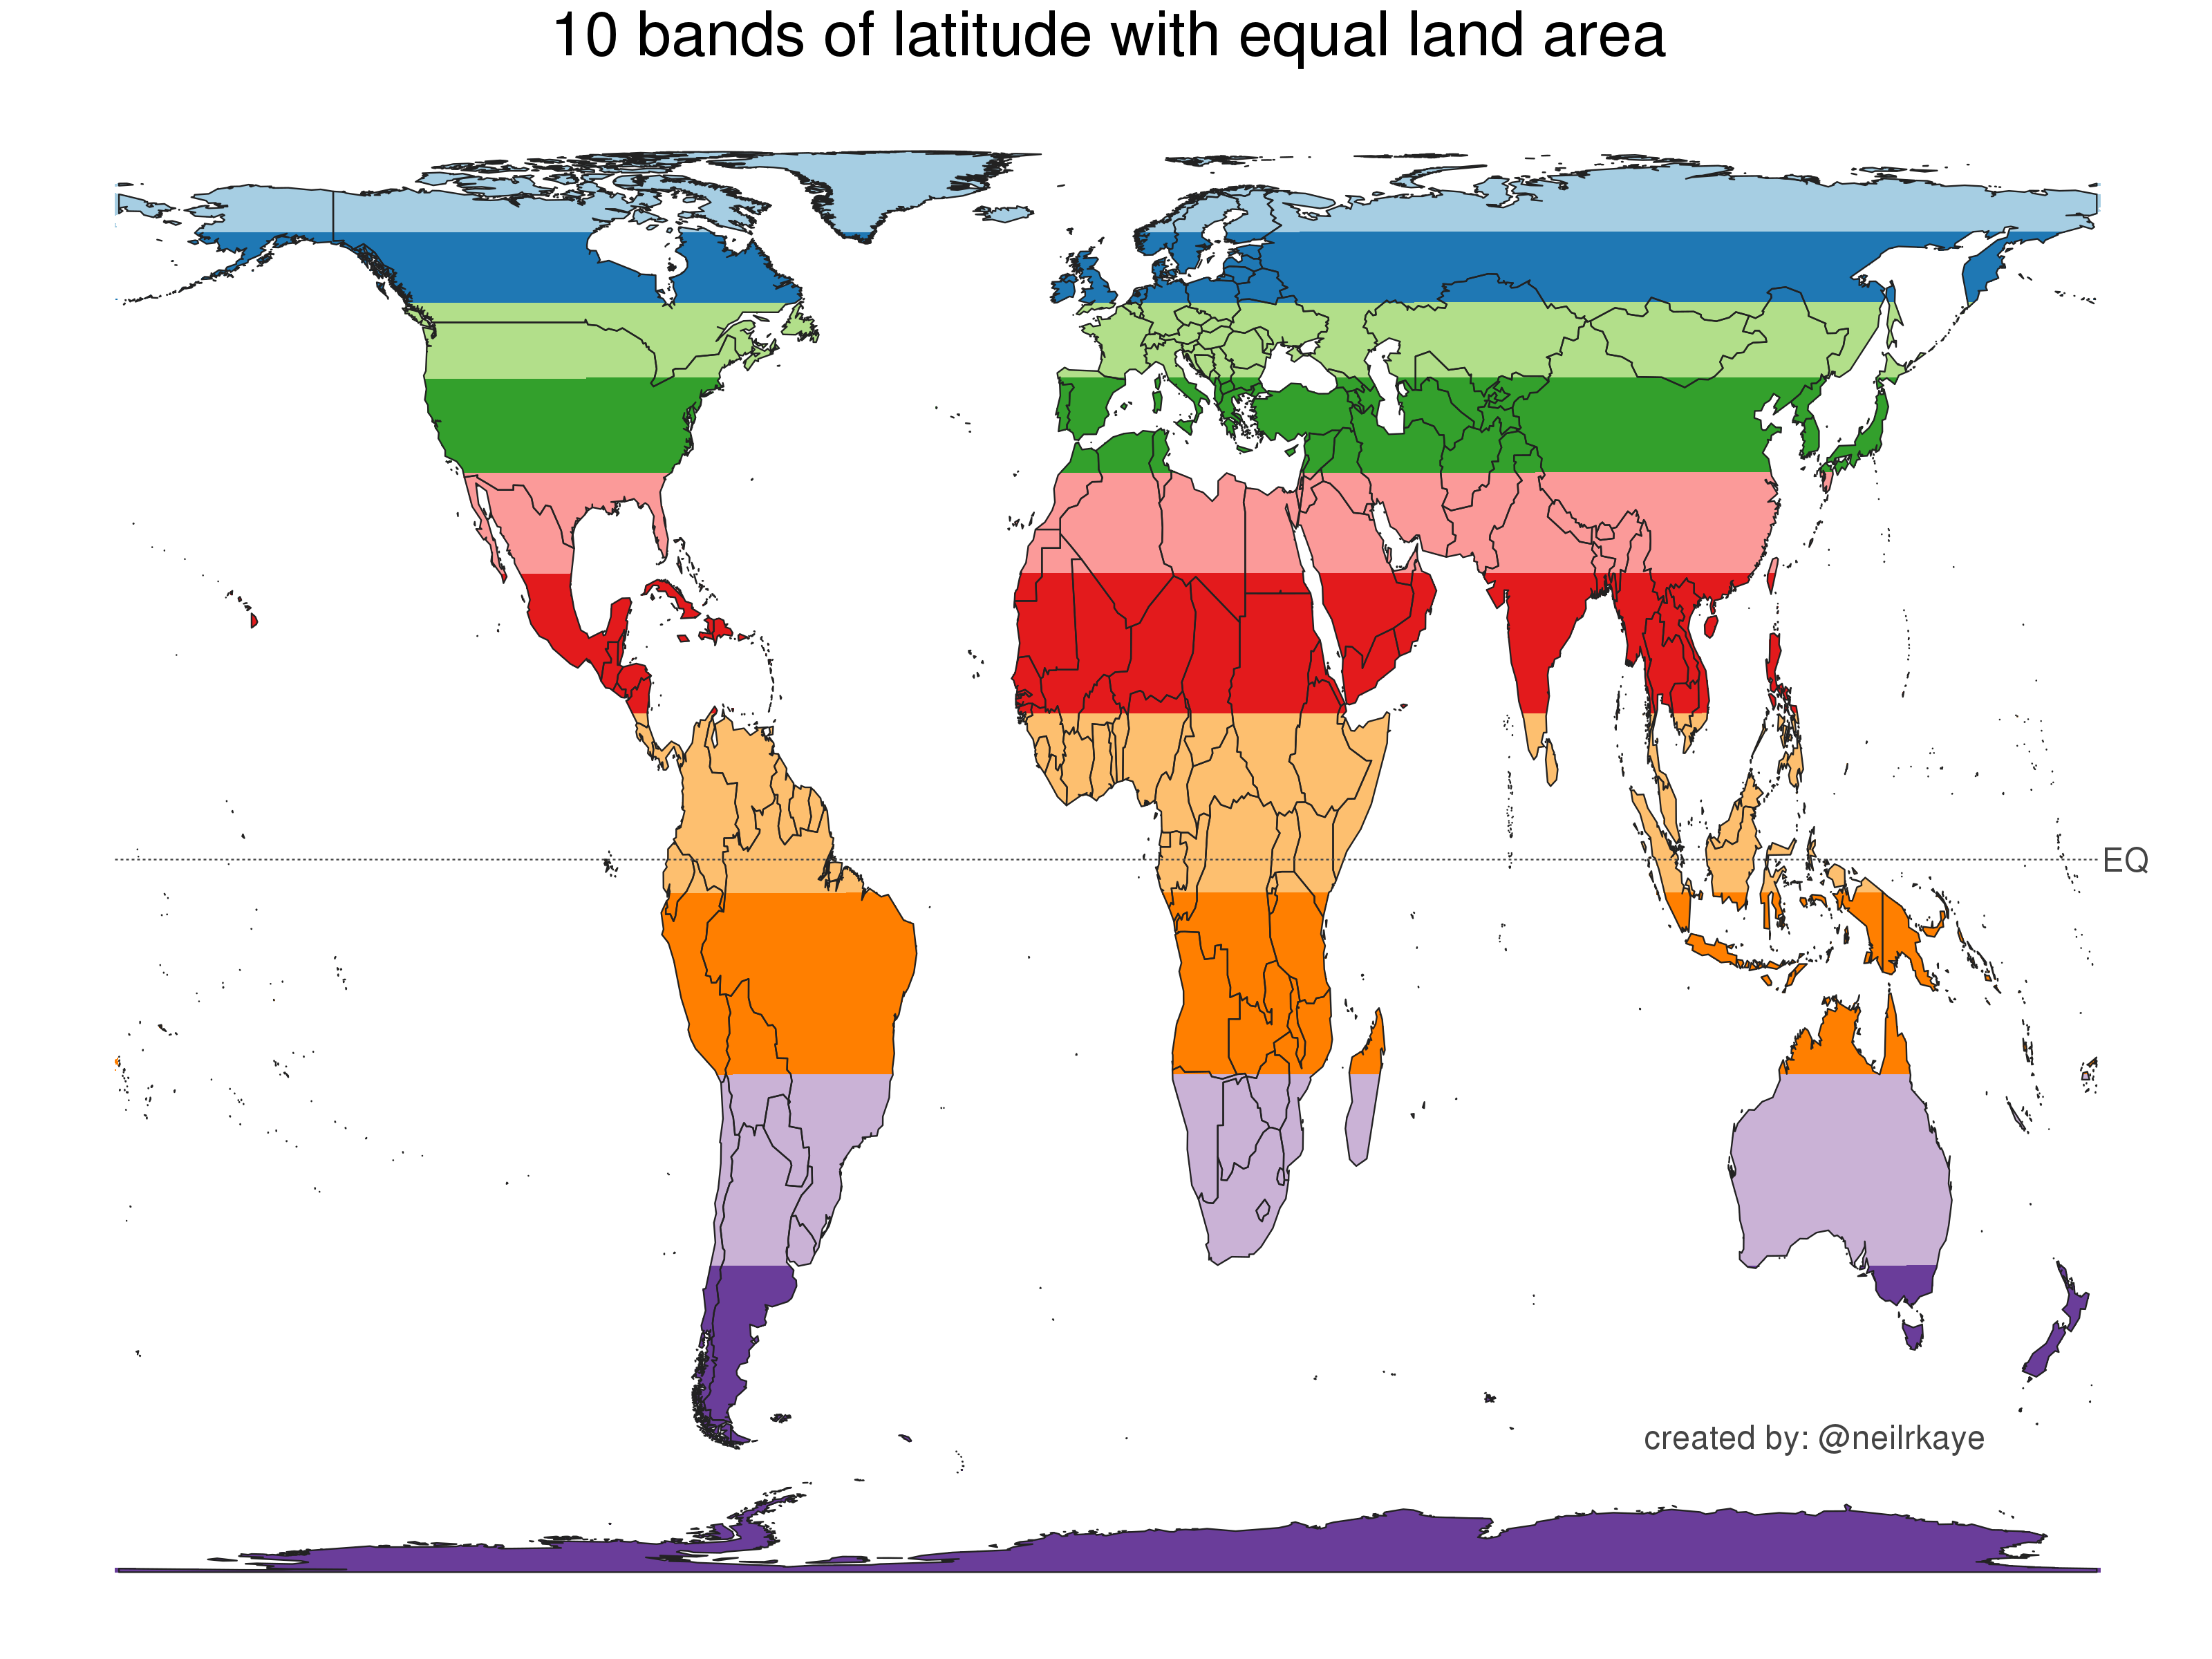

Lets see how birds are distributed acording their latitude

In [11]:
def plot_samples_per_latitude(data, n_lat_bins=10):
    """
    Create a histogram showing number of Birds per latitude band
    """
    # Convert latitude to numeric
    lat = pd.to_numeric(data['Centroid.Latitude'], errors='coerce')

    # Remove NaN values
    lat = lat[~np.isnan(lat)]

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create histogram
    counts, bins, _ = ax.hist(lat, bins=n_lat_bins, color='skyblue',
                             edgecolor='black', alpha=0.7)

    # Add count labels on top of each bar
    for i in range(len(counts)):
        ax.text(bins[i] + (bins[i+1]-bins[i])/2, counts[i],
                f'{int(counts[i])}',
                horizontalalignment='center',
                verticalalignment='bottom')

    # Customize plot
    ax.set_title('Number of Birds per Latitude Band', pad=20)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Number of Birds')

    # Add grid
    ax.grid(True, alpha=0.2)

    # Add total sample size
    ax.text(0.98, 0.98, f'Total Birds = {len(lat)}',
            transform=ax.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

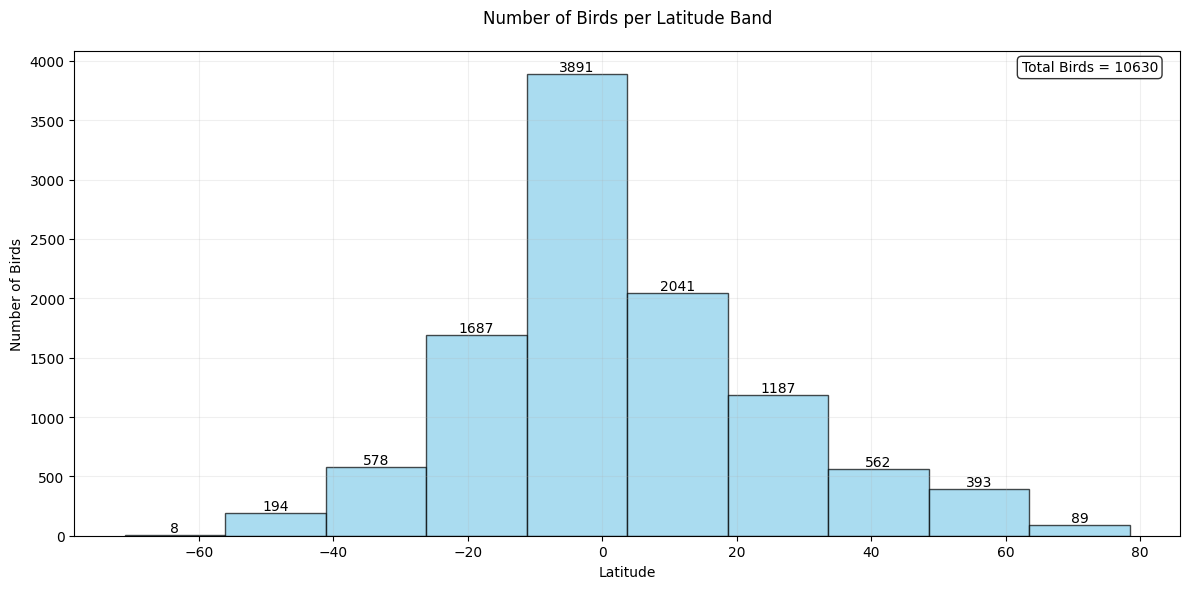

In [12]:
# Create the plot
fig = plot_samples_per_latitude(df)
plt.show()

simple histogram showing the number of birds per latitude band

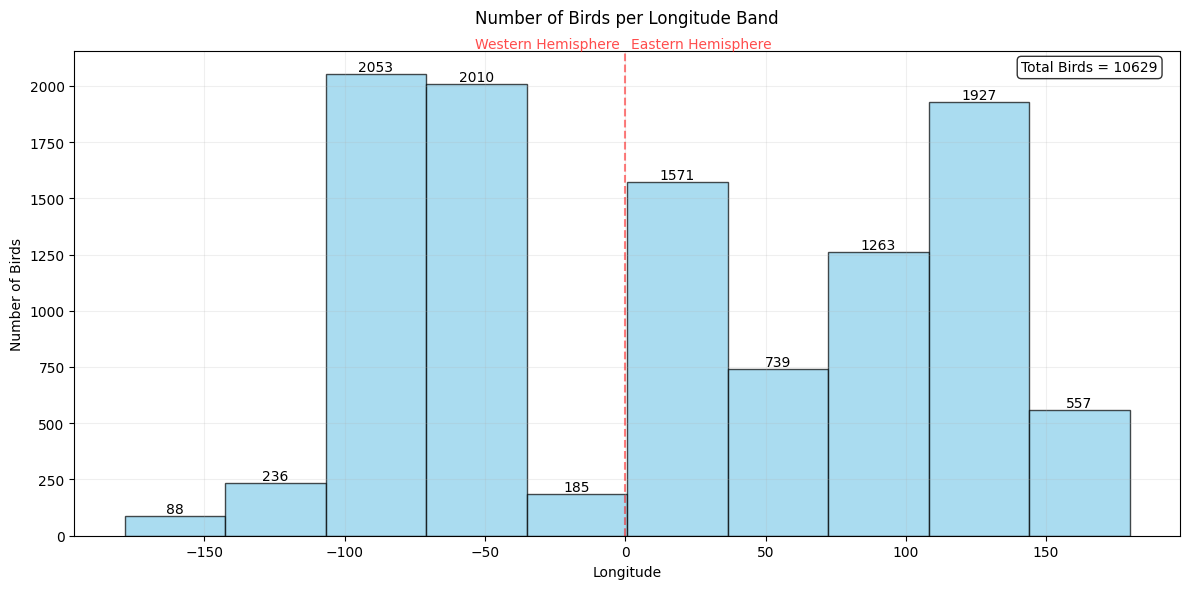

In [13]:
def plot_samples_per_longitude(data, n_lon_bins=10):
    """
    Create a histogram showing number of Birds per longitude band
    """
    # Convert longitude to numeric
    lon = pd.to_numeric(data['Centroid.Longitude'], errors='coerce')

    # Remove NaN values
    lon = lon[~np.isnan(lon)]

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create histogram
    counts, bins, _ = ax.hist(lon, bins=n_lon_bins, color='skyblue',
                             edgecolor='black', alpha=0.7)

    # Add count labels on top of each bar
    for i in range(len(counts)):
        ax.text(bins[i] + (bins[i+1]-bins[i])/2, counts[i],
                f'{int(counts[i])}',
                horizontalalignment='center',
                verticalalignment='bottom')

    # Customize plot
    ax.set_title('Number of Birds per Longitude Band', pad=20)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Number of Birds')

    # Add grid
    ax.grid(True, alpha=0.2)

    # Add total sample size
    ax.text(0.98, 0.98, f'Total Birds = {len(lon)}',
            transform=ax.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add hemisphere lines and labels
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax.text(2, ax.get_ylim()[1], 'Eastern Hemisphere',
            color='red', alpha=0.7, ha='left', va='bottom')
    ax.text(-2, ax.get_ylim()[1], 'Western Hemisphere',
            color='red', alpha=0.7, ha='right', va='bottom')

    plt.tight_layout()
    return fig


fig = plot_samples_per_longitude(df)
plt.show()

# Conservation Status Analysis

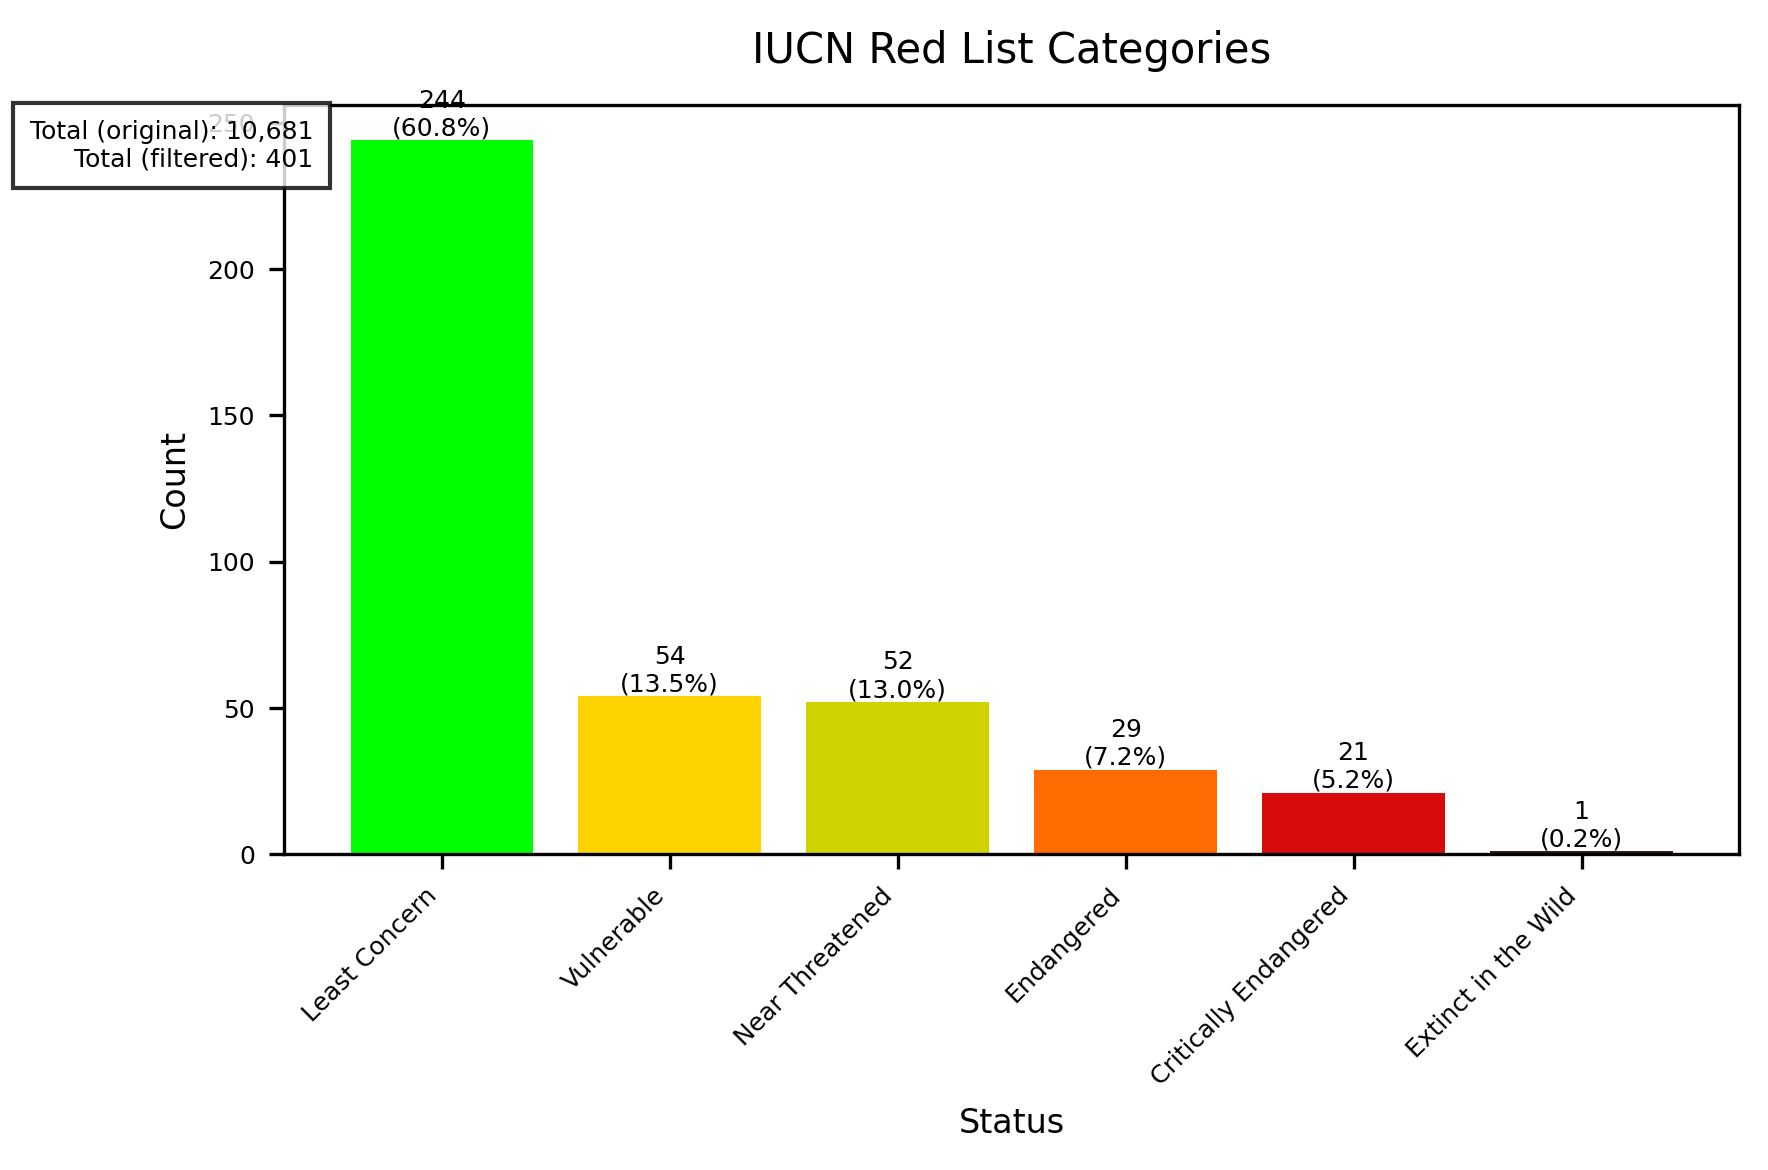

In [51]:
def plot_redlist_distribution(df, figsize=(6, 4), dpi=300):
    """
    Creates a histogram/distribution plot of Red List categories with smaller dimensions
    """
    # Define valid categories and filter
    valid_categories = [
        'Least Concern',
        'Vulnerable',
        'Endangered',
        'Critically Endangered',
        'Extinct in the Wild',
        'Near Threatened',
        'Extinct'
    ]

    df_filtered = df[df['redlistCategory'].isin(valid_categories)]
    df_filtered = df_filtered[df_filtered['Order1'] == 'Psittaciformes']



    # Define IUCN Red List colors
    colors = {
        'Least Concern': '#00FF00',        # Green
        'Vulnerable': '#FFD300',# Yellow
        'Near Threatened': '#CFD300',
        'Endangered': '#FF6B00',           # Orange
        'Critically Endangered': '#D60B0B', # Red
        'Extinct in the Wild': '#2D1F15',  # Dark Brown
        'Extinct': '#000000',              # Black
    }

    # Calculate value counts and percentages
    counts = df_filtered['redlistCategory'].value_counts()
    total_filtered = len(df_filtered)
    total_original = len(df)

    # Create figure with smaller size
    plt.figure(figsize=figsize, dpi=dpi)

    # Create bar plot
    bars = plt.bar(range(len(counts)), counts,
                  color=[colors.get(x, '#808080') for x in counts.index])

    # Customize plot with smaller font sizes
    plt.title('IUCN Red List Categories', pad=10, fontsize=10)
    plt.xlabel('Status', fontsize=8)
    plt.ylabel('Count', fontsize=8)

    # Rotate x-axis labels with smaller font
    plt.xticks(range(len(counts)), counts.index, rotation=45, ha='right', fontsize=6)
    plt.yticks(fontsize=6)

    # Add count labels with smaller font
    for bar in bars:
        height = bar.get_height()
        percentage = (height/total_filtered) * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=6)

    # Add both totals to upper right
    plt.text(0.02, 0.98,
             f'Total (original): {total_original:,}\nTotal (filtered): {total_filtered:,}',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             horizontalalignment='right',
             fontsize=6)

    plt.tight_layout()

    return plt.gcf()

# Usage:
fig = plot_redlist_distribution(df)
plt.show()


# Morphological Analysis

In [15]:
traits = [
    'Beak.Length_Culmen',
    'Beak.Length_Nares',
    'Beak.Width',
    'Beak.Depth',
    'Tarsus.Length',
    'Wing.Length',
    'Kipps.Distance',
    'Hand-Wing.Index',
    'Tail.Length',
    'Mass'
]

In [16]:
unique_values = df['Family1'].unique()
print(unique_values)

['Leiotrichidae' 'Phasianidae' 'Anatidae' 'Columbidae' 'Caprimulgidae'
 'Apodidae' 'Rallidae' 'Gruidae' 'Ciconiidae' 'Ardeidae' 'Charadriidae'
 'Scolopacidae' 'Laridae' 'Picidae' 'Laniidae' 'Bombycillidae' 'Paridae'
 'Alaudidae' 'Acrocephalidae' 'Phylloscopidae' 'Sylviidae' 'Regulidae'
 'Sturnidae' 'Muscicapidae' 'Prunellidae' 'Motacillidae' 'Fringillidae'
 'Calcariidae' 'Emberizidae' 'Turnicidae' 'Strigidae' 'Cracidae'
 'Megalaimidae' 'Lybiidae' 'Ramphastidae' 'Galbulidae' 'Bucconidae'
 'Bucerotidae' 'Trogonidae' 'Coraciidae' 'Brachypteraciidae'
 'Leptosomidae' 'Todidae' 'Alcedinidae' 'Meropidae' 'Cuculidae'
 'Psittacidae' 'Hemiprocnidae' 'Trochilidae' 'Musophagidae' 'Tytonidae'
 'Podargidae' 'Otididae' 'Aramidae' 'Thinocoridae' 'Jacanidae'
 'Burhinidae' 'Haematopodidae' 'Ibidorhynchidae' 'Glareolidae'
 'Accipitridae' 'Falconidae' 'Podicipedidae' 'Anhingidae'
 'Phalacrocoracidae' 'Scopidae' 'Phoenicopteridae' 'Threskiornithidae'
 'Pelecanidae' 'Cathartidae' 'Pittidae' 'Eurylaimidae' '

We have 246 families of birds in the Dataset
We notice weird family name 4.6 and 22.8 on row 5271 and 5451

In [17]:
print(len(unique_values))

246


How many species per family?

In [18]:
# Group by 'Family1' and count unique species
species_count = df.groupby('Family1')['scientificName'].nunique()

# Reset the index to make 'Family1' a column instead of an index
species_count = species_count.reset_index()

# Rename the columns for clarity
species_count.columns = ['Family', 'Number of Species']

# Sort by the number of species in descending order if needed
species_count = species_count.sort_values('Number of Species', ascending=False)

# Save the result to an Excel file
#species_count.to_excel('species_per_family.xlsx', index=False)

# Optionally, print the result
print(species_count)

              Family  Number of Species
236       Tyrannidae                448
225       Thraupidae                401
185      Psittacidae                379
54        Columbidae                340
81       Furnariidae                324
..               ...                ...
73         Eupetidae                  1
213  Steatornithidae                  1
69       Elachuridae                  1
68           Dulidae                  1
0               22.8                  1

[245 rows x 2 columns]


exclude families that have less than 50 species

Maybe filter by system or Habitat and take birds that are on one continent

In [19]:
# Filter out families with less than 50 species
filtered_species_count = species_count[species_count['Number of Species'] >= 50]

# Sort by the number of species in descending order
filtered_species_count = filtered_species_count.sort_values('Number of Species', ascending=False)

# Save the filtered result to an Excel file
filtered_species_count.to_excel('species_per_family_filtered.xlsx', index=False)

# Optionally, print the result
print(filtered_species_count)

              Family  Number of Species
236       Tyrannidae                448
225       Thraupidae                401
185      Psittacidae                379
54        Columbidae                340
81       Furnariidae                324
..               ...                ...
107         Lybiidae                 53
38      Cardinalidae                 52
144  Pachycephalidae                 52
85      Grallariidae                 51
193     Ramphastidae                 50

[64 rows x 2 columns]


From the rest of the families take only 30 species per family in order to reduce the dataset size

In [20]:
# Get the list of filtered families
filtered_families = filtered_species_count['Family'].tolist()

# For each filtered family, take only the first 50 species
result = pd.DataFrame()
for family in filtered_families:
    family_data = df[df['Family1'] == family].drop_duplicates(subset='scientificName').head(30)
    result = pd.concat([result, family_data])

result.to_excel('30_species_per_family.xlsx', )

In [21]:
df_filtered = result

In [22]:
# Define morphological trait columns
morphological_traits = [
    'scientificName',  # including species name for reference
    'Beak.Length_Culmen',
    'Beak.Length_Nares',
    'Beak.Width',
    'Beak.Depth',
    'Tarsus.Length',
    'Wing.Length',
    'Kipps.Distance',
    'Hand-Wing.Index',
    'Tail.Length',
    'Mass'
]


# Calculating similarity matrix based on morphological traits

In [23]:
def save_large_similarity_matrix(similarity_df, filename, format='csv', chunk_size=1000):
    """
    Save large similarity matrix in chunks using memory-efficient formats

    Parameters:
    similarity_df: Pandas DataFrame containing similarity matrix
    filename: Base filename without extension
    format: 'csv', 'hdf', 'npz', or 'parquet'
    chunk_size: Number of rows to process at once
    """
    try:
        total_rows = len(similarity_df)

        if format == 'csv':
            # Save to CSV in chunks
            for start_idx in range(0, total_rows, chunk_size):
                end_idx = min(start_idx + chunk_size, total_rows)
                chunk = similarity_df.iloc[start_idx:end_idx]

                if start_idx == 0:
                    # First chunk - write with header
                    chunk.to_csv(f'{filename}.csv', mode='w')
                else:
                    # Subsequent chunks - append without header
                    chunk.to_csv(f'{filename}.csv', mode='a', header=False)

                print(f"Processed rows {start_idx} to {end_idx} of {total_rows}")

        elif format == 'npz':
            # Save as compressed NumPy array
            similarity_matrix = similarity_df.values
            np.savez_compressed(f'{filename}.npz',
                              matrix=similarity_matrix,
                              index=similarity_df.index.values,
                              columns=similarity_df.columns.values)

        elif format == 'hdf':
            # Save to HDF5 format
            with pd.HDFStore(f'{filename}.h5') as store:
                for start_idx in range(0, total_rows, chunk_size):
                    end_idx = min(start_idx + chunk_size, total_rows)
                    chunk = similarity_df.iloc[start_idx:end_idx]
                    store.append('similarity_matrix', chunk)
                    print(f"Processed rows {start_idx} to {end_idx} of {total_rows}")

        elif format == 'parquet':
            # Save to Parquet format
            similarity_df.to_parquet(f'{filename}.parquet')

        print(f"\nSimilarity matrix successfully saved to {filename}.{format}")

        # Print file size
        import os
        file_extension = {'csv': '.csv', 'npz': '.npz',
                         'hdf': '.h5', 'parquet': '.parquet'}
        file_size = os.path.getsize(f"{filename}{file_extension[format]}")
        print(f"File size: {file_size / (1024*1024):.2f} MB")

        return True

    except Exception as e:
        print(f"Error saving similarity matrix: {str(e)}")
        return False

In [24]:
def standardize_traits(df_traits, traits):
    """Standardize/Normalize morphological traits."""
    scaler = StandardScaler()
    standardized_traits = scaler.fit_transform(df_traits[traits])
    species_names = df_traits['scientificName'].values
    return standardized_traits, species_names

def compute_similarity(standardized_traits):
    """
    Compute cosine similarity between species and ensure values are in [-1,1] range.

    Parameters:
        standardized_traits: numpy array of standardized morphological traits
    Returns:
        similarity_matrix: numpy array of pairwise similarities
    """
    # Compute cosine similarity
    similarity_matrix = cosine_similarity(standardized_traits)

    # Clip values to ensure they're in [-1,1] range
    similarity_matrix = np.clip(similarity_matrix, -1, 1)

    # Additional checks
    print("Similarity matrix range:",
          f"min: {similarity_matrix.min():.3f}, max: {similarity_matrix.max():.3f}")

    # Verify similarity range
    if not np.all((similarity_matrix >= -1) & (similarity_matrix <= 1)):
        print("Warning: Original similarity values were outside [-1,1] range")

    return similarity_matrix


# Create a similarity network from the similarity matrix

Create a network where edges are created only if similarity exceeds the threshold.

In [25]:
def create_threshold_network(similarity_matrix, species_names, df_data, threshold=0.5):
    """
    Create network with node attributes and similarity-based edges.

    Parameters:
        similarity_matrix: Matrix of pairwise species similarities
        species_names: List of species names
        df_data: DataFrame containing species attributes (lat, long, family, etc.)
        threshold: Minimum similarity value to create an edge
    """
    G_threshold = nx.Graph()

    # Add nodes with attributes
    for species in species_names:
        # Get species data from DataFrame
        species_data = df_data[df_data['scientificName'] == species].iloc[0]

        # Add node with attributes
        G_threshold.add_node(
            species,
            latitude=species_data['Centroid.Latitude'],
            longitude=species_data['Centroid.Longitude'],
            family=species_data['Family1'],
            scientific_name=species
        )

    # Add edges based on similarity
    for i in range(len(species_names)):
        for j in range(i+1, len(species_names)):
            if similarity_matrix[i][j] >= threshold:
                G_threshold.add_edge(
                    species_names[i],
                    species_names[j],
                    weight=similarity_matrix[i][j]
                )


    return G_threshold

Create a network by connecting the nodes with the k most similar neighbors

In [26]:
def create_knn_network(similarity_matrix, species_names, df_data, k=5):
    """
    Create network with node attributes and k-nearest neighbor connections.
    Prevents self-loops and ensures proper KNN connections.

    Parameters:
        similarity_matrix: Matrix of pairwise species similarities
        species_names: List of species names
        df_data: DataFrame containing species attributes (lat, long, family, etc.)
        k: Number of nearest neighbors to connect for each node
    """
    G_knn = nx.Graph()

    # Add nodes with attributes
    for species in species_names:
        # Get species data from DataFrame
        species_data = df_data[df_data['scientificName'] == species].iloc[0]

        # Add node with attributes
        G_knn.add_node(
            species,
            latitude=species_data['Centroid.Latitude'],
            longitude=species_data['Centroid.Longitude'],
            family=species_data['Family1'],
            scientific_name=species
        )

    # Create a mask for the diagonal to exclude self-connections
    np.fill_diagonal(similarity_matrix, -np.inf)  # Set diagonal to negative infinity

    # Add edges based on k-nearest neighbors
    for i in range(len(species_names)):
        # Get indices of k most similar species (excluding self)
        similarities = similarity_matrix[i]
        # Argsort in descending order (most similar first)
        most_similar_indices = np.argsort(similarities)[::-1][:k]

        # Add edges to k nearest neighbors
        for j in most_similar_indices:
            G_knn.add_edge(
                species_names[i],
                species_names[j],
                weight=similarity_matrix[i][j]
            )

    #Check for self-loops
    self_loops = list(nx.selfloop_edges(G_knn))
    if self_loops:
        print("Warning: Self-loops found in the network:")
        for edge in self_loops:
            print(f"Self-loop found for node: {edge[0]}")
    else:
        print("No self-loops found in the network")

    # Additional network statistics
    print(f"\nNetwork Statistics:")
    print(f"Number of nodes: {G_knn.number_of_nodes()}")
    print(f"Number of edges: {G_knn.number_of_edges()}")
    print(f"Average degree: {sum(dict(G_knn.degree()).values()) / G_knn.number_of_nodes():.2f}")

    return G_knn

In [27]:
# 1. Data Preparation
# Create a copy of the data with species names and morphological traits
# Drop any rows with missing values (NaN)
df_traits = df_filtered[['scientificName'] + traits].copy()
df_traits = df_traits.dropna()

# 2. Data Standardization
# StandardScaler transforms features to have mean=0 and variance=1
# This ensures all traits contribute equally regardless of their original scales
standardized_traits, species_names = standardize_traits(df_traits, traits)

# 3. Similarity Calculation
# Compute cosine similarity between all pairs of species
# Result is a square matrix where each cell[i,j] is similarity between species i and j
similarity_matrix = compute_similarity(standardized_traits)



Similarity matrix range: min: -0.994, max: 1.000


In [28]:
# Visualize similarity distribution
def plot_similarity_distribution(similarity_matrix):
    """
    Plot the distribution of similarity values to help with thresholding
    """
    plt.figure(figsize=(10, 6))
    # Get upper triangle values
    upper_tri = similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)]

    plt.hist(upper_tri, bins=50)
    plt.title('Distribution of Similarity Values')
    plt.xlabel('Similarity')
    plt.ylabel('Frequency')



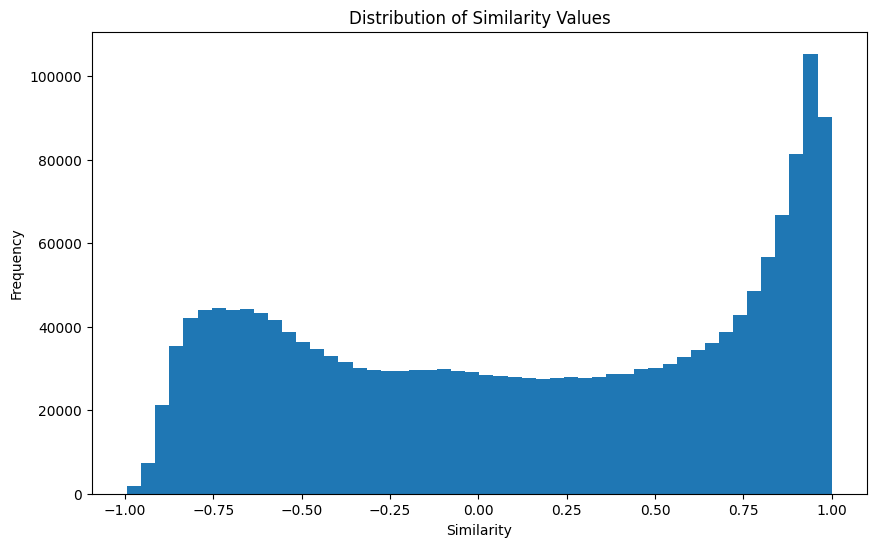

In [29]:
plot_similarity_distribution(similarity_matrix)

In [30]:
# Save similarity matrix
similarity_df = pd.DataFrame(similarity_matrix,
                           index=species_names,
                           columns=species_names)
similarity_df.to_excel('similarity_matrix.xlsx')

In [31]:

threshold = np.percentile(similarity_matrix, 95)
G_treshold = create_threshold_network(
        similarity_matrix=similarity_matrix,
        species_names=species_names,
        df_data=df_filtered,
        threshold=threshold
    )


# Print summary statistics
print("Network Summary:")
print(f"Number of nodes: {G_treshold.number_of_nodes()}")
print(f"Number of edges: {G_treshold.number_of_edges()}")

Network Summary:
Number of nodes: 1920
Number of edges: 91200


In [32]:
G_knn = create_knn_network(
        similarity_matrix=similarity_matrix,
        species_names=species_names,
        df_data=df_filtered,
        k=5
)

No self-loops found in the network

Network Statistics:
Number of nodes: 1920
Number of edges: 6848
Average degree: 7.13


In [33]:
def save_graph_to_graphml(G, filename, compress=True):
    """
    Save network to GraphML format with proper attribute handling

    Parameters:
    G: NetworkX graph
    filename: Output filename (with or without extension)
    compress: Boolean, whether to compress the output file
    """
    try:
        # Ensure proper file extension
        if not filename.endswith('.graphml'):
            filename += '.graphml'

        if compress and not filename.endswith('.gz'):
            filename += '.gz'

        # Convert all attributes to strings to ensure compatibility
        G_save = G.copy()

        # Handle node attributes
        for node, attrs in G_save.nodes(data=True):
            for key, value in attrs.items():
                if isinstance(value, (list, dict, set)):
                    G_save.nodes[node][key] = str(value)
                elif pd.isna(value):
                    G_save.nodes[node][key] = ''

        # Handle edge attributes
        for u, v, attrs in G_save.edges(data=True):
            for key, value in attrs.items():
                if isinstance(value, (list, dict, set)):
                    G_save[u][v][key] = str(value)
                elif pd.isna(value):
                    G_save[u][v][key] = ''

        # Save the graph
        nx.write_graphml(G_save, filename)

        print(f"Graph successfully saved to {filename}")

        # Print some statistics
        print(f"\nSaved graph statistics:")
        print(f"Nodes: {G_save.number_of_nodes()}")
        print(f"Edges: {G_save.number_of_edges()}")
        print(f"Node attributes: {list(next(iter(G_save.nodes(data=True)))[1].keys())}")
        edge_attrs = list(next(iter(G_save.edges(data=True)))[2].keys()) if G_save.number_of_edges() > 0 else []
        print(f"Edge attributes: {edge_attrs}")

        return True

    except Exception as e:
        print(f"Error saving graph: {str(e)}")
        return False

In [34]:
save_graph_to_graphml(G_knn, 'morphological_similarity_network.graphml')

Graph successfully saved to morphological_similarity_network.graphml.gz

Saved graph statistics:
Nodes: 1920
Edges: 6848
Node attributes: ['latitude', 'longitude', 'family', 'scientific_name']
Edge attributes: ['weight']


True

In [35]:
def analyze_connectivity(G):
    # Check if graph is connected
    is_connected = nx.is_connected(G)

    # Get connected components
    components = list(nx.connected_components(G))
    n_components = len(components)

    # Get largest component
    largest_component = max(components, key=len)

    # Calculate size metrics
    total_nodes = G.number_of_nodes()
    largest_component_size = len(largest_component)
    largest_component_ratio = largest_component_size / total_nodes

    # Create subgraph of largest component
    G_largest = G.subgraph(largest_component)

    # Print analysis
    print(f"Graph Connectivity Analysis:")
    print(f"Is connected: {is_connected}")
    print(f"Number of components: {n_components}")
    print(f"Total nodes: {total_nodes}")
    print(f"Total edges: {G.number_of_edges()}")
    print(f"Largest component size: {largest_component_size}")
    print(f"Largest component ratio: {largest_component_ratio:.2%}")

    # Visualize components
    plt.figure(figsize=(15, 10))

    # Position all nodes using spring layout
    pos = nx.spring_layout(G)

    # Draw each component in a different color
    colors = plt.cm.rainbow(np.linspace(0, 1, n_components))
    for idx, component in enumerate(components):
        nx.draw_networkx_nodes(G, pos,
                             nodelist=list(component),
                             node_color=[colors[idx]],
                             node_size=100,
                             alpha=0.7)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Add labels for larger components
    component_sizes = [len(c) for c in components]
    for idx, (component, size) in enumerate(zip(components, component_sizes)):
        if size > total_nodes * 0.05:  # Label components with >5% of nodes
            center_x = np.mean([pos[node][0] for node in component])
            center_y = np.mean([pos[node][1] for node in component])
            plt.text(center_x, center_y, f'Component {idx+1}\n({size} nodes)',
                    horizontalalignment='center',
                    verticalalignment='center',
                    bbox=dict(facecolor='white', alpha=0.7))

    plt.title("Connected Components Visualization")
    plt.axis('off')
    plt.show()

    return {
        'is_connected': is_connected,
        'n_components': n_components,

        'largest_component_size': largest_component_size,
        'largest_component_ratio': largest_component_ratio,

    }

Graph Connectivity Analysis:
Is connected: True
Number of components: 1
Total nodes: 1920
Total edges: 6848
Largest component size: 1920
Largest component ratio: 100.00%


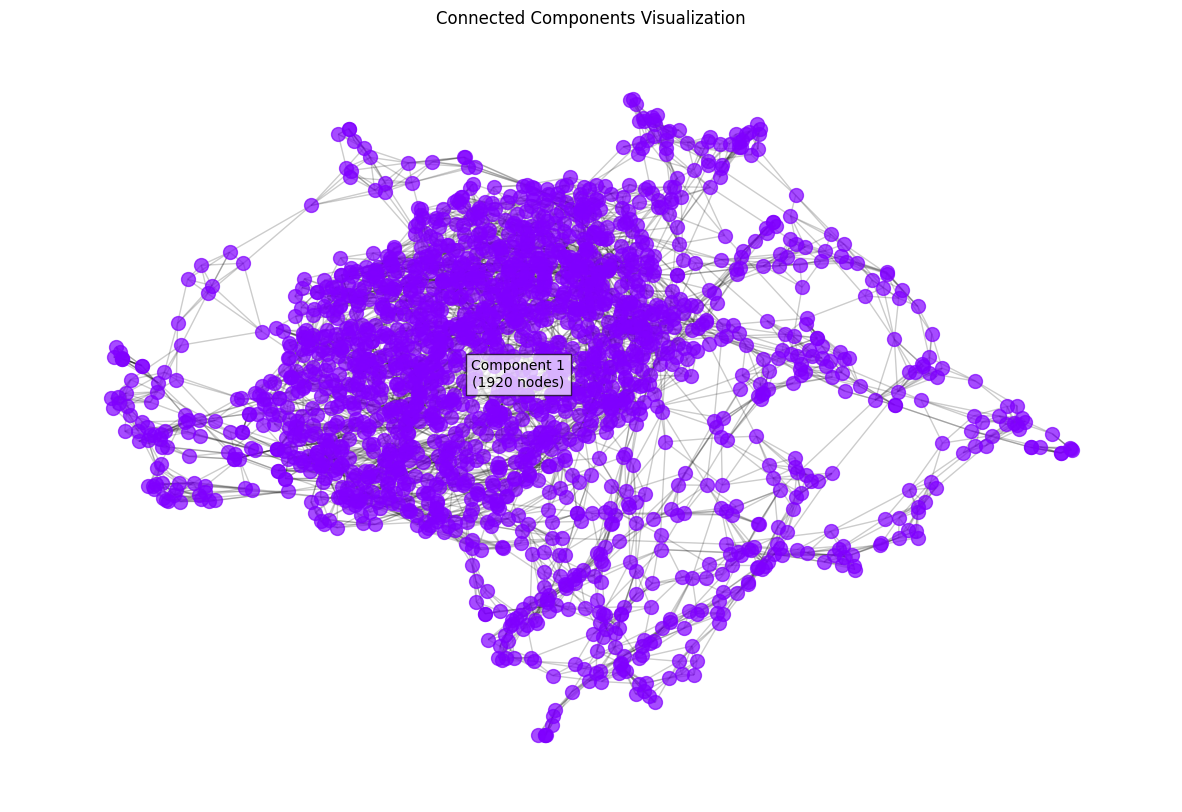

{'is_connected': True,
 'n_components': 1,
 'largest_component_size': 1920,
 'largest_component_ratio': 1.0}

In [36]:
analyze_connectivity(G_knn)

Take only the largest component

In [37]:
# Find the connected components
components = list(nx.connected_components(G_knn))

# Get the largest component
largest_component = max(components, key=len)

# Create a subgraph from the largest component
largest_subgraph = G_knn.subgraph(largest_component)


Graph Connectivity Analysis:
Is connected: True
Number of components: 1
Total nodes: 1920
Total edges: 6848
Largest component size: 1920
Largest component ratio: 100.00%


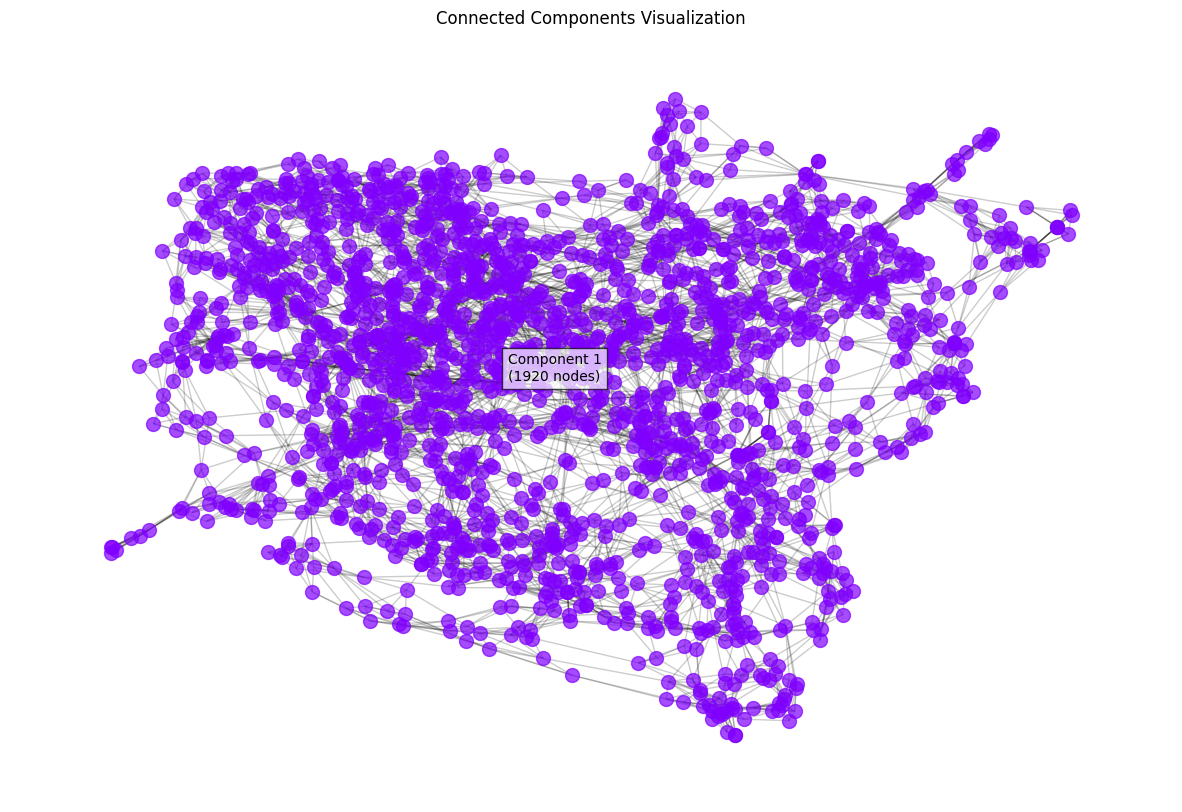

{'is_connected': True,
 'n_components': 1,
 'largest_component_size': 1920,
 'largest_component_ratio': 1.0}

In [38]:
analyze_connectivity(largest_subgraph)

In [39]:
save_graph_to_graphml(largest_subgraph, 'morphological_similarity_network_largest.graphml')

Graph successfully saved to morphological_similarity_network_largest.graphml.gz

Saved graph statistics:
Nodes: 1920
Edges: 6848
Node attributes: ['latitude', 'longitude', 'family', 'scientific_name']
Edge attributes: ['weight']


True

In [40]:
import math
import folium
from folium import plugins
import seaborn as sns
import networkx as nx
import json
def plot_network_on_map(G, output_file='species_network_map.html'):
    """
    Plot network on an interactive map using folium, with static edge visualization.
    """
    # Filter out nodes with invalid coordinates
    valid_nodes = []
    for node, data in G.nodes(data=True):
        try:
            lat = float(data['latitude'])
            lon = float(data['longitude'])
            if not (math.isnan(lat) or math.isnan(lon)):
                valid_nodes.append(node)
        except (ValueError, TypeError, KeyError):
            continue

    # Create subgraph with only valid coordinates
    G_valid = G.subgraph(valid_nodes).copy()

    if len(G_valid) == 0:
        print("No valid coordinates found in the graph")
        return None

    # Calculate center of the map
    lats = [float(data['latitude']) for _, data in G_valid.nodes(data=True)]
    lons = [float(data['longitude']) for _, data in G_valid.nodes(data=True)]
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)

    # Create base map
    m = folium.Map(location=[center_lat, center_lon],
                  zoom_start=4,
                  tiles='CartoDB positron')

    # Create a color map for families
    families = list(set(data['family'] for _, data in G_valid.nodes(data=True)))
    color_palette = sns.color_palette("husl", len(families)).as_hex()
    family_colors = dict(zip(families, color_palette))

    # Add edges first (so they appear under the nodes)
    for edge in G_valid.edges():
        node1, node2 = edge
        try:
            lat1 = float(G_valid.nodes[node1]['latitude'])
            lon1 = float(G_valid.nodes[node1]['longitude'])
            lat2 = float(G_valid.nodes[node2]['latitude'])
            lon2 = float(G_valid.nodes[node2]['longitude'])

            # Create edge as a PolyLine
            folium.PolyLine(
                locations=[[lat1, lon1], [lat2, lon2]],
                weight=1,
                color='gray',
                opacity=0.5
            ).add_to(m)
        except (ValueError, TypeError):
            continue

    # Add nodes (species locations)
    for node, data in G_valid.nodes(data=True):
        try:
            lat = float(data['latitude'])
            lon = float(data['longitude'])

            popup_text = f"""
            <b>Species:</b> {node}<br>
            <b>Family:</b> {data['family']}<br>
            <b>Latitude:</b> {lat:.4f}<br>
            <b>Longitude:</b> {lon:.4f}<br>
            <b>Connections:</b> {G_valid.degree(node)}
            """

            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                popup=folium.Popup(popup_text, max_width=300),
                color=family_colors[data['family']],
                fill=True,
                fill_color=family_colors[data['family']],
                fill_opacity=0.7,
                weight=2,
            ).add_to(m)

        except (ValueError, TypeError):
            continue

    # Add legend
    legend_html = """
    <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white;
                padding: 10px; border: 2px solid grey; border-radius: 5px;">
    <h4>Families</h4>
    """
    for family, color in family_colors.items():
        legend_html += f"""
        <p>
            <span style="background-color: {color}; padding: 0 5px; margin-right: 5px;
                        border-radius: 50%; border: 1px solid black;">&nbsp;</span>
            {family}
        </p>
        """
    legend_html += "</div>"
    m.get_root().html.add_child(folium.Element(legend_html))

    # Add fullscreen option
    plugins.Fullscreen().add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Print summary
    print(f"\nMapping Summary:")
    print(f"Total nodes in original graph: {len(G)}")
    print(f"Nodes with valid coordinates: {len(G_valid)}")
    print(f"Nodes excluded due to invalid coordinates: {len(G) - len(G_valid)}")

    # Save map
    m.save(output_file)
    print(f"Map saved to {output_file}")

    return m

In [41]:

map_obj = plot_network_on_map(largest_subgraph)



Mapping Summary:
Total nodes in original graph: 1920
Nodes with valid coordinates: 1910
Nodes excluded due to invalid coordinates: 10
Map saved to species_network_map.html
